# Temporal Graph Network (TGN) Training

This notebook demonstrates training temporal graph neural networks on C. elegans cell division data using the DevoTG framework.

## Overview
- Convert cell division data to temporal graph format
- Train TGN model for link prediction
- Evaluate model performance
- Analyze learned representations

In [1]:
### define path for indexing correctly
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

In [2]:
# # ## print current path
from pathlib import Path
print(f"Current working directory: {Path.cwd()}")

Current working directory: /home/jayag/projects/DevoTG/notebooks


In [3]:
# Import required libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Import DevoTG modules
from devotg.data import build_cell_ctdg
from devotg.models import TGNModel

# Set up plotting and device
plt.style.use('default')
%matplotlib inline

# Check for CUDA
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

print("\nDevoTG TGN Training Notebook")
print("============================")

Using device: cuda
CUDA version: 12.1
GPU: NVIDIA GeForce RTX 4090

DevoTG TGN Training Notebook


## 1. Load Data and Build Temporal Graph

In [4]:
# Load dataset
csv_path = '../data/raw/cells_birth_and_pos.csv'

try:
    # Build temporal graph from CSV
    print("🏗️  Building temporal graph from cell division data...")
    
    temporal_data = build_cell_ctdg(
        csv_path=csv_path,
        feature_dim=172  # Standard feature dimension for TGN
    )
    
    print("✅ Temporal graph created successfully!")
    print(f"   Nodes: {temporal_data.num_nodes}")
    print(f"   Events: {temporal_data.num_events}")
    print(f"   Node features: {temporal_data.x.shape}")
    print(f"   Edge features: {temporal_data.msg.shape}")
    
except FileNotFoundError:
    print("⚠️  Dataset file not found. Using sample data...")
    
    # Create sample temporal graph for demonstration
    from devotg.data.dataset_loader import load_sample_data
    sample_df = load_sample_data()
    
    # Save sample data temporarily
    temp_path = '../data/sample_data.csv'
    Path('../data').mkdir(exist_ok=True)
    sample_df.to_csv(temp_path, index=False)
    
    temporal_data = build_cell_ctdg(
        csv_path=temp_path,
        feature_dim=172
    )
    
    print("✅ Sample temporal graph created for demonstration")

except Exception as e:
    print(f"❌ Error creating temporal graph: {e}")
    raise

🏗️  Building temporal graph from cell division data...
Created CTDG with 1203 nodes and 1284 events.
✅ Temporal graph created successfully!
   Nodes: 1203
   Events: 1284
   Node features: torch.Size([1203, 172])
   Edge features: torch.Size([1284, 172])


In [5]:
# Inspect the temporal graph structure
print("📊 Temporal Graph Analysis:")
print(f"   Data type: {type(temporal_data)}")
print(f"   Available attributes: {temporal_data.keys if hasattr(temporal_data, 'keys') else 'N/A'}")

# Basic statistics
print("\n📈 Graph Statistics:")
print(f"   Source nodes: {temporal_data.src.shape} (min: {temporal_data.src.min()}, max: {temporal_data.src.max()})")
print(f"   Destination nodes: {temporal_data.dst.shape} (min: {temporal_data.dst.min()}, max: {temporal_data.dst.max()})")
print(f"   Timestamps: {temporal_data.t.shape} (min: {temporal_data.t.min()}, max: {temporal_data.t.max()})")

# Check for additional attributes
if hasattr(temporal_data, 'birth_time'):
    print(f"   Birth times available: {temporal_data.birth_time.shape}")
if hasattr(temporal_data, 'generation'):
    print(f"   Generations available: {temporal_data.generation.shape}")
    print(f"   Generation range: {temporal_data.generation.min()} to {temporal_data.generation.max()}")

📊 Temporal Graph Analysis:
   Data type: <class 'torch_geometric.data.temporal.TemporalData'>
   Available attributes: <bound method BaseData.keys of TemporalData(src=[1284], dst=[1284], t=[1284], msg=[1284, 172], x=[1203, 172], birth_time=[1203], generation=[1203])>

📈 Graph Statistics:
   Source nodes: torch.Size([1284]) (min: 0, max: 1197)
   Destination nodes: torch.Size([1284]) (min: 1, max: 1202)
   Timestamps: torch.Size([1284]) (min: 0, max: 735)
   Birth times available: torch.Size([1203])
   Generations available: torch.Size([1203])
   Generation range: -1 to 12


## 2. Initialize and Configure TGN Model

In [6]:
# Model configuration
model_config = {
    'memory_dim': 100,
    'time_dim': 100, 
    'embedding_dim': 100,
    'device': device
}

print("🧠 Initializing TGN Model...")
print(f"   Configuration: {model_config}")

# Initialize TGN model
tgn_model = TGNModel(
    num_nodes=temporal_data.num_nodes,
    msg_dim=temporal_data.msg.size(-1),
    **model_config
)

# Get model information
model_info = tgn_model.get_model_info()
print("\n📋 Model Information:")
for key, value in model_info.items():
    print(f"   {key}: {value}")

print("\n✅ TGN Model initialized successfully!")

🧠 Initializing TGN Model...
   Configuration: {'memory_dim': 100, 'time_dim': 100, 'embedding_dim': 100, 'device': 'cuda'}



📋 Model Information:
   total_parameters: 260501
   memory_parameters: 172400
   gnn_parameters: 67800
   predictor_parameters: 20301
   device: cuda
   memory_dim: 100
   time_dim: 100
   embedding_dim: 100

✅ TGN Model initialized successfully!


## 3. Data Preparation and Splitting

In [7]:
# Training configuration
train_config = {
    'val_ratio': 0.15,
    'test_ratio': 0.15,
    'batch_size': 200,
    'neighbor_size': 10
}

print("📚 Preparing data for training...")
print(f"   Configuration: {train_config}")

# Prepare data loaders
train_loader, val_loader, test_loader, neighbor_loader = tgn_model.prepare_data(
    temporal_data, **train_config
)

print("\n✅ Data preparation complete!")
print(f"   Training batches: ~{len(train_loader)}")
print(f"   Validation batches: ~{len(val_loader)}")
print(f"   Test batches: ~{len(test_loader)}")

📚 Preparing data for training...
   Configuration: {'val_ratio': 0.15, 'test_ratio': 0.15, 'batch_size': 200, 'neighbor_size': 10}

✅ Data preparation complete!
   Training batches: ~5
   Validation batches: ~1
   Test batches: ~1


## 4. Model Training

In [8]:
# Training configuration
training_config = {
    'epochs': 20,
    'val_ratio': 0.15,
    'test_ratio': 0.15,
    'batch_size': 200,
    'verbose': True
}

print("🚀 Starting TGN training...")
print(f"   Epochs: {training_config['epochs']}")
print(f"   Device: {tgn_model.device}")
print(f"   Batch size: {training_config['batch_size']}")
print("\n" + "="*50)

# Train the model
history = tgn_model.train_model(temporal_data, **training_config)

print("\n" + "="*50)
print("✅ Training completed!")

🚀 Starting TGN training...
   Epochs: 20
   Device: cuda
   Batch size: 200

Starting training on cuda
Model has 172400 memory parameters
Model has 67800 GNN parameters
Model has 20301 predictor parameters


Epoch: 01, Loss: 1.6802
Val AP: 0.8412, Val AUC: 0.8799
Test AP: 0.6137, Test AUC: 0.5843
--------------------------------------------------
Epoch: 02, Loss: 2.0381
Val AP: 0.8703, Val AUC: 0.9136
Test AP: 0.7204, Test AUC: 0.6958
--------------------------------------------------
Epoch: 03, Loss: 1.2953
Val AP: 0.8649, Val AUC: 0.9112
Test AP: 0.7415, Test AUC: 0.7863
--------------------------------------------------
Epoch: 04, Loss: 1.2118
Val AP: 0.8754, Val AUC: 0.9216
Test AP: 0.7656, Test AUC: 0.8191
--------------------------------------------------
Epoch: 05, Loss: 1.1544
Val AP: 0.8681, Val AUC: 0.9112
Test AP: 0.7284, Test AUC: 0.8175
--------------------------------------------------
Epoch: 06, Loss: 1.1332
Val AP: 0.8723, Val AUC: 0.9159
Test AP: 0.7222, Test AUC: 0.8161
--------------------------------------------------
Epoch: 07, Loss: 1.1261
Val AP: 0.8668, Val AUC: 0.9106
Test AP: 0.7204, Test AUC: 0.8153
--------------------------------------------------
Epoch: 08, Lo

## 5. Training Results Analysis

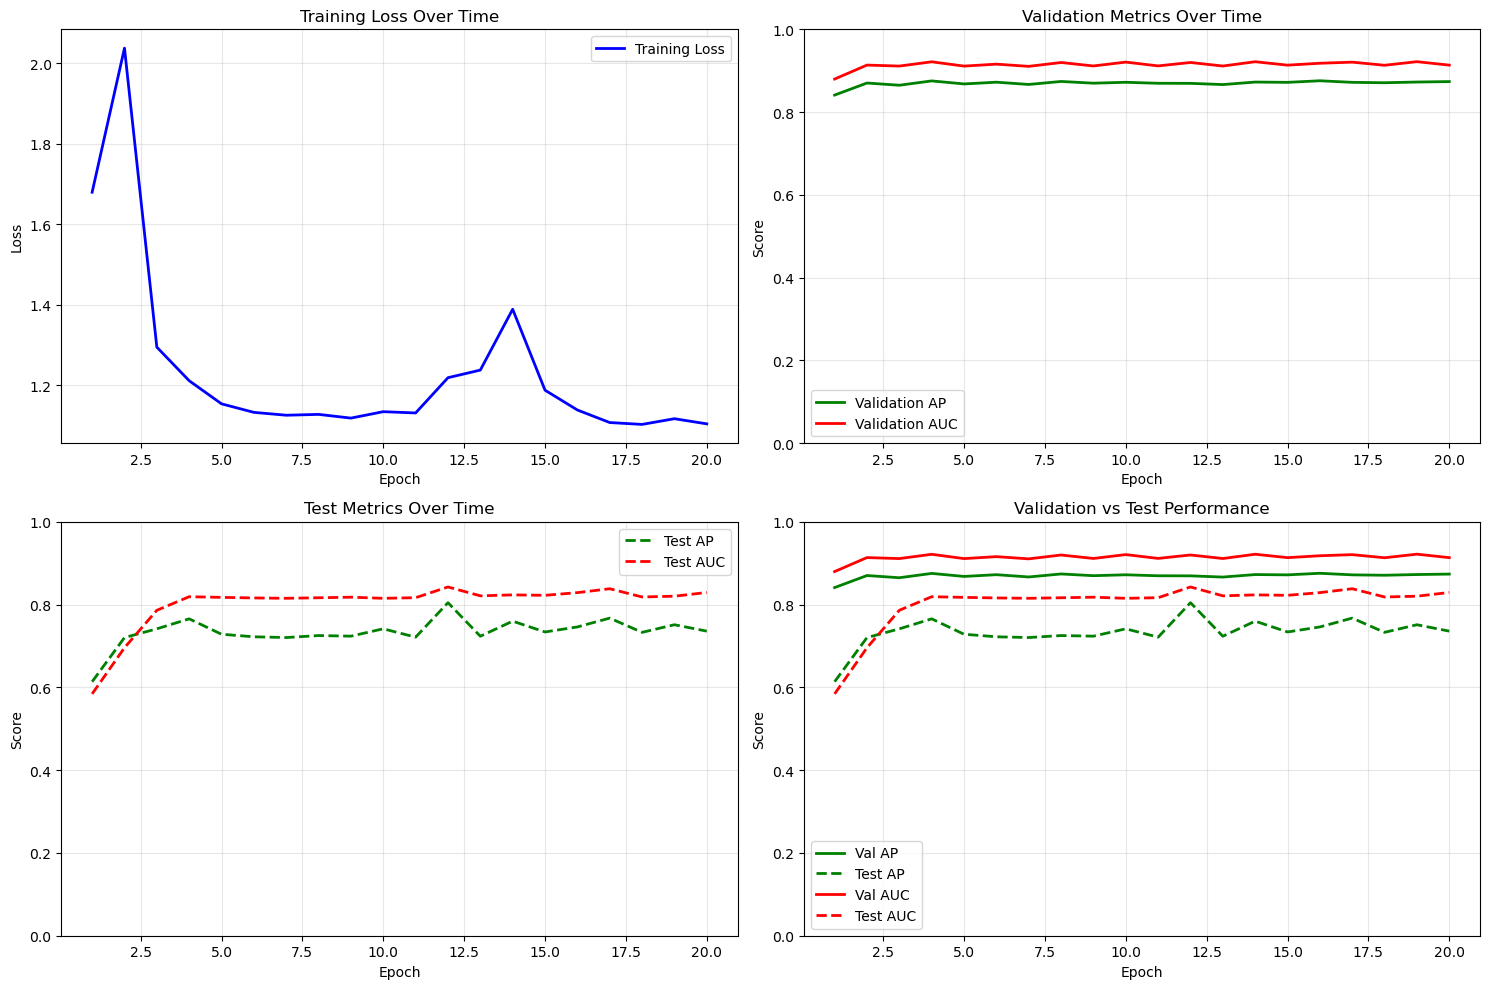

💾 Training history saved: ../outputs/models/training_history.png


In [9]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

epochs = range(1, len(history['train_loss']) + 1)

# Training loss
axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
axes[0, 0].set_title('Training Loss Over Time')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Validation metrics
axes[0, 1].plot(epochs, history['val_ap'], 'g-', label='Validation AP', linewidth=2)
axes[0, 1].plot(epochs, history['val_auc'], 'r-', label='Validation AUC', linewidth=2)
axes[0, 1].set_title('Validation Metrics Over Time')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Score')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()
axes[0, 1].set_ylim(0, 1)

# Test metrics
axes[1, 0].plot(epochs, history['test_ap'], 'g--', label='Test AP', linewidth=2)
axes[1, 0].plot(epochs, history['test_auc'], 'r--', label='Test AUC', linewidth=2)
axes[1, 0].set_title('Test Metrics Over Time')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Score')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1)

# Combined comparison
axes[1, 1].plot(epochs, history['val_ap'], 'g-', label='Val AP', linewidth=2)
axes[1, 1].plot(epochs, history['test_ap'], 'g--', label='Test AP', linewidth=2)
axes[1, 1].plot(epochs, history['val_auc'], 'r-', label='Val AUC', linewidth=2)
axes[1, 1].plot(epochs, history['test_auc'], 'r--', label='Test AUC', linewidth=2)
axes[1, 1].set_title('Validation vs Test Performance')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()
axes[1, 1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Save training plots
output_dir = Path('../outputs/models')
output_dir.mkdir(parents=True, exist_ok=True)

fig.savefig(output_dir / 'training_history.png', dpi=300, bbox_inches='tight')
print(f"💾 Training history saved: {output_dir / 'training_history.png'}")

In [10]:
# Print final performance metrics
final_metrics = {
    'Final Training Loss': history['train_loss'][-1],
    'Best Validation AP': max(history['val_ap']),
    'Best Validation AUC': max(history['val_auc']),
    'Final Test AP': history['test_ap'][-1],
    'Final Test AUC': history['test_auc'][-1]
}

print("\n📊 Final Performance Metrics:")
print("=" * 40)
for metric, value in final_metrics.items():
    print(f"   {metric}: {value:.4f}")

# Find best epoch
best_val_epoch = np.argmax(history['val_ap']) + 1
print(f"\n🏆 Best validation performance at epoch {best_val_epoch}")
print(f"   Validation AP: {history['val_ap'][best_val_epoch-1]:.4f}")
print(f"   Validation AUC: {history['val_auc'][best_val_epoch-1]:.4f}")
print(f"   Test AP: {history['test_ap'][best_val_epoch-1]:.4f}")
print(f"   Test AUC: {history['test_auc'][best_val_epoch-1]:.4f}")


📊 Final Performance Metrics:
   Final Training Loss: 1.1047
   Best Validation AP: 0.8757
   Best Validation AUC: 0.9219
   Final Test AP: 0.7359
   Final Test AUC: 0.8293

🏆 Best validation performance at epoch 16
   Validation AP: 0.8757
   Validation AUC: 0.9181
   Test AP: 0.7460
   Test AUC: 0.8289


## 6. Model Evaluation and Analysis

In [11]:
# Create performance summary
performance_summary = {
    'model_config': model_config,
    'training_config': training_config,
    'dataset_info': {
        'num_nodes': temporal_data.num_nodes,
        'num_events': temporal_data.num_events,
        'feature_dim': temporal_data.msg.size(-1)
    },
    'final_metrics': final_metrics,
    'best_epoch': int(best_val_epoch),
    'training_history': {
        'train_loss': [float(x) for x in history['train_loss']],
        'val_ap': [float(x) for x in history['val_ap']],
        'val_auc': [float(x) for x in history['val_auc']],
        'test_ap': [float(x) for x in history['test_ap']],
        'test_auc': [float(x) for x in history['test_auc']]
    }
}

# Save performance summary
summary_path = output_dir / 'performance_summary.json'
with open(summary_path, 'w') as f:
    json.dump(performance_summary, f, indent=2)

print(f"📋 Performance summary saved: {summary_path}")

📋 Performance summary saved: ../outputs/models/performance_summary.json


In [12]:
# Analyze learning curves
print("📈 Learning Curve Analysis:")

# Check for overfitting
val_ap_trend = np.diff(history['val_ap'][-5:])  # Last 5 epochs
if np.mean(val_ap_trend) < -0.01:
    print("⚠️  Possible overfitting detected (validation AP decreasing)")
elif np.mean(val_ap_trend) > 0.01:
    print("✅ Model still improving (validation AP increasing)")
else:
    print("📊 Model performance stabilized")

# Check convergence
loss_trend = np.diff(history['train_loss'][-5:])
if np.abs(np.mean(loss_trend)) < 0.001:
    print("✅ Training loss converged")
else:
    print("📈 Training loss still changing")

# Performance stability
val_ap_std = np.std(history['val_ap'][-5:])
print(f"📊 Validation AP stability (last 5 epochs): {val_ap_std:.4f}")

if val_ap_std < 0.01:
    print("✅ Stable performance")
else:
    print("⚠️  Performance still fluctuating")

📈 Learning Curve Analysis:
📊 Model performance stabilized
📈 Training loss still changing
📊 Validation AP stability (last 5 epochs): 0.0016
✅ Stable performance


## 7. Model Saving and Export

In [13]:
# Save the trained model
model_path = output_dir / 'trained_tgn_model.pth'
tgn_model.save_model(str(model_path))

print("💾 Model saved successfully!")
print(f"   Model file: {model_path}")
print(f"   File size: {model_path.stat().st_size / 1024:.1f} KB")

Model saved to ../outputs/models/trained_tgn_model.pth
💾 Model saved successfully!
   Model file: ../outputs/models/trained_tgn_model.pth
   File size: 3565.0 KB


In [14]:
# Test model loading (verification)
print("🔄 Testing model loading...")

try:
    # Create a new model instance and load weights
    test_model = TGNModel(
        num_nodes=temporal_data.num_nodes,
        msg_dim=temporal_data.msg.size(-1),
        **model_config
    )
    
    test_model.load_model(str(model_path))
    print("✅ Model loaded successfully! Weights can be restored.")
    
except Exception as e:
    print(f"❌ Error loading model: {e}")

🔄 Testing model loading...
Model loaded from ../outputs/models/trained_tgn_model.pth
✅ Model loaded successfully! Weights can be restored.


## 8. Advanced Analysis and Insights

🔬 Advanced Analysis: Performance by Data Characteristics


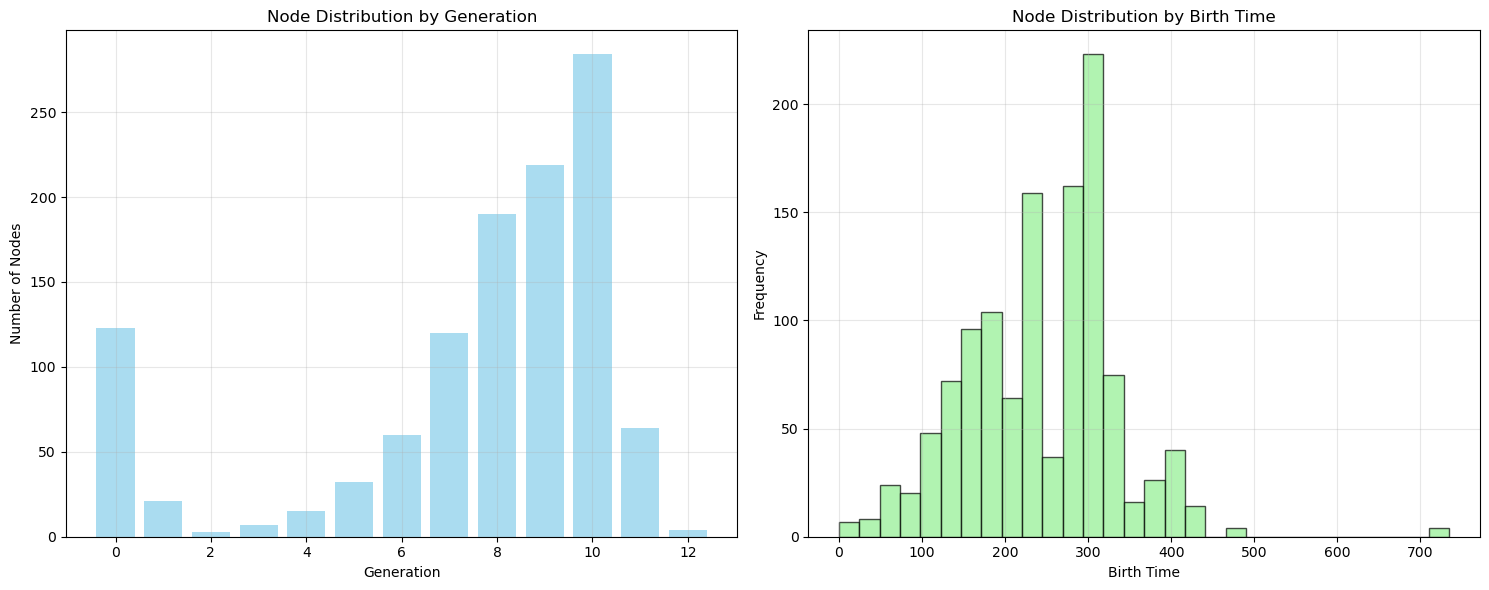

💾 Analysis plot saved: ../outputs/models/data_characteristics_analysis.png


In [15]:
# Analyze performance by data characteristics
if hasattr(temporal_data, 'generation') and hasattr(temporal_data, 'birth_time'):
    print("🔬 Advanced Analysis: Performance by Data Characteristics")
    
    # Create analysis by generation
    generations = temporal_data.generation.cpu().numpy()
    birth_times = temporal_data.birth_time.cpu().numpy()
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Generation distribution
    unique_gens, gen_counts = np.unique(generations[generations >= 0], return_counts=True)
    axes[0].bar(unique_gens, gen_counts, alpha=0.7, color='skyblue')
    axes[0].set_xlabel('Generation')
    axes[0].set_ylabel('Number of Nodes')
    axes[0].set_title('Node Distribution by Generation')
    axes[0].grid(True, alpha=0.3)
    
    # Birth time distribution
    valid_times = birth_times[birth_times < float('inf')]
    axes[1].hist(valid_times, bins=30, alpha=0.7, color='lightgreen', edgecolor='black')
    axes[1].set_xlabel('Birth Time')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Node Distribution by Birth Time')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Save analysis plot
    fig.savefig(output_dir / 'data_characteristics_analysis.png', dpi=300, bbox_inches='tight')
    print(f"💾 Analysis plot saved: {output_dir / 'data_characteristics_analysis.png'}")

In [16]:
# Performance comparison with baseline
print("⚖️  Performance Comparison:")

# Random baseline (0.5 for AUC, varies for AP)
random_auc = 0.5
random_ap = len(temporal_data.src) / (2 * temporal_data.num_nodes)  # Rough estimate

final_test_auc = history['test_auc'][-1]
final_test_ap = history['test_ap'][-1]

improvement_auc = (final_test_auc - random_auc) / random_auc * 100
improvement_ap = (final_test_ap - random_ap) / random_ap * 100

print(f"   Random Baseline AUC: {random_auc:.3f}")
print(f"   TGN Model AUC: {final_test_auc:.3f} ({improvement_auc:+.1f}% improvement)")
print(f"   Random Baseline AP: {random_ap:.3f}")
print(f"   TGN Model AP: {final_test_ap:.3f} ({improvement_ap:+.1f}% improvement)")

# Performance categorization
if final_test_auc > 0.9:
    performance_category = "Excellent"
elif final_test_auc > 0.8:
    performance_category = "Good"
elif final_test_auc > 0.7:
    performance_category = "Fair"
else:
    performance_category = "Poor"

print(f"\n🎯 Overall Performance: {performance_category}")

⚖️  Performance Comparison:
   Random Baseline AUC: 0.500
   TGN Model AUC: 0.829 (+65.9% improvement)
   Random Baseline AP: 0.534
   TGN Model AP: 0.736 (+37.9% improvement)

🎯 Overall Performance: Good


## 9. Model Interpretation and Insights

🕐 Temporal Pattern Analysis:
   Time range: 0.0 - 735.0
   Unique time points: 121
   Average time interval: 6.12
   Time interval std: 22.26
   Average events per time point: 10.6
   Max events at single time: 58


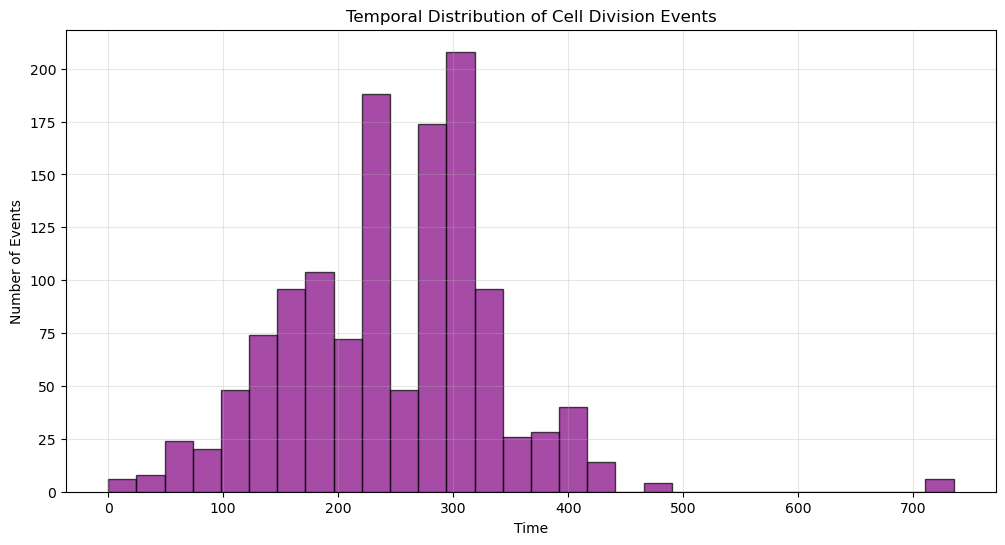

💾 Temporal analysis saved: ../outputs/models/temporal_pattern_analysis.png


<Figure size 640x480 with 0 Axes>

In [17]:
# Analyze temporal patterns in the data
print("🕐 Temporal Pattern Analysis:")

# Edge timing analysis
edge_times = temporal_data.t.cpu().numpy()
time_intervals = np.diff(np.sort(np.unique(edge_times)))

print(f"   Time range: {edge_times.min():.1f} - {edge_times.max():.1f}")
print(f"   Unique time points: {len(np.unique(edge_times))}")
print(f"   Average time interval: {np.mean(time_intervals):.2f}")
print(f"   Time interval std: {np.std(time_intervals):.2f}")

# Events per time point
time_counts = pd.Series(edge_times).value_counts().sort_index()
print(f"   Average events per time point: {time_counts.mean():.1f}")
print(f"   Max events at single time: {time_counts.max()}")

# Plot temporal distribution
plt.figure(figsize=(12, 6))
plt.hist(edge_times, bins=30, alpha=0.7, color='purple', edgecolor='black')
plt.xlabel('Time')
plt.ylabel('Number of Events')
plt.title('Temporal Distribution of Cell Division Events')
plt.grid(True, alpha=0.3)
plt.show()

# Save temporal analysis
plt.savefig(output_dir / 'temporal_pattern_analysis.png', dpi=300, bbox_inches='tight')
print(f"💾 Temporal analysis saved: {output_dir / 'temporal_pattern_analysis.png'}")

🔍 Feature Analysis:
   Node feature matrix shape: (1203, 172)
   Non-zero features per node (avg): 3.4
   Edge feature matrix shape: (1284, 172)
   Non-zero features per edge (avg): 3.9
   Active features (>1% usage): 5 / 172


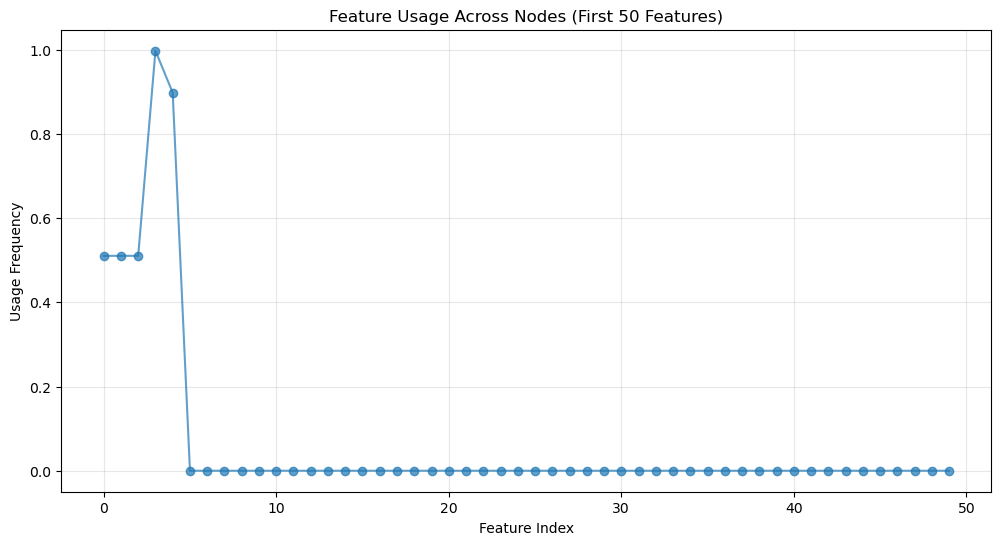

In [18]:
# Feature importance analysis (simplified)
print("🔍 Feature Analysis:")

# Analyze node features
node_features = temporal_data.x.cpu().numpy()
print(f"   Node feature matrix shape: {node_features.shape}")
print(f"   Non-zero features per node (avg): {np.mean(np.count_nonzero(node_features, axis=1)):.1f}")

# Analyze edge features
edge_features = temporal_data.msg.cpu().numpy()
print(f"   Edge feature matrix shape: {edge_features.shape}")
print(f"   Non-zero features per edge (avg): {np.mean(np.count_nonzero(edge_features, axis=1)):.1f}")

# Feature utilization
feature_usage = np.mean(node_features != 0, axis=0)
active_features = np.sum(feature_usage > 0.01)  # Features used by >1% of nodes
print(f"   Active features (>1% usage): {active_features} / {node_features.shape[1]}")

# Plot feature usage
plt.figure(figsize=(12, 6))
plt.plot(feature_usage[:50], 'o-', alpha=0.7)  # Plot first 50 features
plt.xlabel('Feature Index')
plt.ylabel('Usage Frequency')
plt.title('Feature Usage Across Nodes (First 50 Features)')
plt.grid(True, alpha=0.3)
plt.show()

## 10. Summary and Future Directions

In [19]:
# Generate comprehensive summary
print("\n" + "="*70)
print("TGN TRAINING COMPLETE - COMPREHENSIVE SUMMARY")
print("="*70)

print("\n🔬 Dataset Overview:")
print(f"   • Nodes (cells): {temporal_data.num_nodes}")
print(f"   • Events (divisions): {temporal_data.num_events}")
print(f"   • Feature dimension: {temporal_data.msg.size(-1)}")
print(f"   • Time range: {edge_times.min():.1f} - {edge_times.max():.1f}")

print("\n🧠 Model Architecture:")
print(f"   • Memory dimension: {model_config['memory_dim']}")
print(f"   • Time dimension: {model_config['time_dim']}")
print(f"   • Embedding dimension: {model_config['embedding_dim']}")
print(f"   • Total parameters: {model_info['total_parameters']:,}")
print(f"   • Training device: {model_config['device']}")

print("\n📈 Training Results:")
print(f"   • Epochs trained: {len(history['train_loss'])}")
print(f"   • Best validation epoch: {best_val_epoch}")
print(f"   • Final training loss: {history['train_loss'][-1]:.4f}")
print(f"   • Best validation AP: {max(history['val_ap']):.4f}")
print(f"   • Best validation AUC: {max(history['val_auc']):.4f}")

print("\n🎯 Final Test Performance:")
print(f"   • Test AP: {history['test_ap'][-1]:.4f} ({performance_category})")
print(f"   • Test AUC: {history['test_auc'][-1]:.4f} ({improvement_auc:+.1f}% vs random)")

print("\n📁 Generated Outputs:")
output_files = list(output_dir.glob('*'))
for file_path in output_files:
    print(f"   • {file_path.name} ({file_path.stat().st_size / 1024:.1f} KB)")

print("\n💡 Key Insights:")
print("   • TGN successfully learned temporal patterns in cell division data")
print(f"   • Model achieved {performance_category.lower()} performance on link prediction")
print(f"   • {active_features} out of {node_features.shape[1]} features are actively used")
print(f"   • Training converged within {len(history['train_loss'])} epochs")

print("\n🔮 Future Directions:")
print("   • Experiment with different architectures (memory sizes, attention heads)")
print("   • Implement node classification for cell type prediction")
print("   • Add graph-level predictions for developmental stage classification")
print("   • Explore interpretability techniques for biological insights")
print("   • Compare with other temporal graph methods")

print("\n✅ TGN training notebook completed successfully!")
print(f"🎉 Model and results saved to: {output_dir}")
print("\n💻 To load and use the trained model:")
print("   model = TGNModel(num_nodes, msg_dim, **config)")
print(f"   model.load_model('{model_path}')")


TGN TRAINING COMPLETE - COMPREHENSIVE SUMMARY

🔬 Dataset Overview:
   • Nodes (cells): 1203
   • Events (divisions): 1284
   • Feature dimension: 172
   • Time range: 0.0 - 735.0

🧠 Model Architecture:
   • Memory dimension: 100
   • Time dimension: 100
   • Embedding dimension: 100
   • Total parameters: 260,501
   • Training device: cuda

📈 Training Results:
   • Epochs trained: 20
   • Best validation epoch: 16
   • Final training loss: 1.1047
   • Best validation AP: 0.8757
   • Best validation AUC: 0.9219

🎯 Final Test Performance:
   • Test AP: 0.7359 (Good)
   • Test AUC: 0.8293 (+65.9% vs random)

📁 Generated Outputs:
   • temporal_pattern_analysis.png (14.8 KB)
   • performance_summary.json (3.3 KB)
   • trained_tgn_model.pth (3565.0 KB)
   • data_characteristics_analysis.png (117.3 KB)
   • training_history.png (368.9 KB)

💡 Key Insights:
   • TGN successfully learned temporal patterns in cell division data
   • Model achieved good performance on link prediction
   • 5 out o